<a href="https://www.kaggle.com/code/awsaf49/detect-fake-text-kerasnlp-tf-torch-jax-train?scriptVersionId=149115499" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# LLM - Detect AI Generated Text
> Identify which essay was written by a large language model

<img src="https://user-images.githubusercontent.com/36858976/279902422-b365f6ef-ef01-49ac-af7f-0bc2ca3ba835.png">

# 🎯 | Motivation

* In this notebook, we will demonstrate the usage of the multi-backend capabilities of `KerasCore` and `KerasNLP` for the **Detecting Fake Text** task.
* Thanks to `KerasCore`, soon to become `Keras 3.0`, which enables seamless execution of this notebook on `TensorFlow`, `Jax`, and `PyTorch` platforms with minimal adjustments required.
* Moreover, this notebook supports both single/multi GPU and TPU training. As time progresses, larger datasets may become available, making TPUs invaluable for training substantial models on these extensive datasets.
* Finally, I am very curious about the effectiveness of this competition, as a few months ago, `OpenAI` shut down their AI Text-Detection Tool due to inaccuracies ([ref](https://www.pcmag.com/news/openai-quietly-shuts-down-ai-text-detection-tool-over-inaccuracies)). So, I'm eager to see how well this competition will address the problem.
<img src="https://i.ibb.co/6Y2Vtgr/openAI.jpg" alt="openAI" border="0">

# 📓 | Notebooks

* Train: [Detect Fake Text: KerasNLP [TF/Torch/JAX][Train]](https://www.kaggle.com/code/awsaf49/detect-fake-text-kerasnlp-tf-torch-jax-train)
* Infer: [Detect Fake Text: KerasNLP [TF/Torch/JAX][Infer]](https://www.kaggle.com/code/awsaf49/detect-fake-text-kerasnlp-tf-torch-jax-infer)

# 🛠 | Install Libraries 

In [1]:
!pip install -q keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install --upgrade -q wandb git+https://github.com/soumik12345/wandb-addons

# 📚 | Import Libraries 

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"  # "jax" or "tensorflow" or "torch" 
# os.environ["WANDB_SILENT"] = "false" # for wandb

import keras_nlp
import keras_core as keras
import keras_core.backend as K


import torch
# import jax
import tensorflow as tf
# from tensorflow import keras
# import tensorflow.keras.backend as K

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.get_cmap('coolwarm')

Using PyTorch backend.


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_26/1252067845.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


## Library Version

In [3]:
print("TensorFlow:", tf.__version__)
# print("JAX:", jax.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.12.0
Keras: 0.1.7
KerasNLP: 0.6.2


# ⚙️ | Configuration

In [4]:
class CFG:
    verbose = 0  # Verbosity
    
    wandb = False  # Weights & Biases logging
    competition = 'llm-detect-ai-generated-text'  # Competition name
    _wandb_kernel = 'awsaf49'  # WandB kernel
    comment = 'DebertaV3-MaxSeq_200-ext_s-torch'  # Comment description
    
    preset = "deberta_v3_base_en"  # Name of pretrained models
    sequence_length = 200  # Input sequence length
    
    device = 'TPU'  # Device
    
    seed = 42  # Random seed
    
    num_folds = 5  # Total folds
    selected_folds = [0, 1, 2]  # Folds to train on
    
    epochs = 3 # Training epochs
    batch_size = 3  # Batch size
    drop_remainder = True  # Drop incomplete batches
    cache = True # Caches data after one iteration, use only with `TPU` to avoid OOM
    
    scheduler = 'cosine'  # Learning rate scheduler
    
    class_names = ["real", "fake"]  # Class names [A, B, C, D, E]
    num_classes = len(class_names)  # Number of classes
    class_labels = list(range(num_classes))  # Class labels [0, 1, 2, 3, 4]
    label2name = dict(zip(class_labels, class_names))  # Label to class name mapping
    name2label = {v: k for k, v in label2name.items()}  # Class name to label mapping

# ♻️ | Reproducibility 
Sets value for random seed to produce similar result in each run.

In [5]:
keras.utils.set_random_seed(CFG.seed)

# 💾 | Hardware
Following codes automatically detects hardware (TPU or GPU). 

In [6]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    try:
        # Connect to TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on TPU', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device

In [7]:
# Initialize GPU/TPU/TPU-VM
strategy, CFG.device = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on GPU | Num of GPUs:  2


# 📁 | Dataset Path 

In [8]:
BASE_PATH = '/kaggle/input/llm-detect-ai-generated-text'

# 📖 | Meta Data 
* `{test|train}_essays.csv`
    * `id` - A unique identifier for each essay.
    * `prompt_id` - Identifies the prompt the essay was written in response to.
    * `text` - The essay text itself.
    * `generated` - Whether the essay was written by a student (0) or generated by an LLM (1). This field is the target and is not present in test_essays.csv.
* **sample_submission.csv** - is the valid sample submission.

## Train Data

# Train Data: 1,378
# Sample:


,id,prompt_id,text,generated,label,name
0,0059830c,0,Cars. Cars have been around since they became ...,0,0,real
1,005db917,0,Transportation is a large necessity in most co...,0,0,real


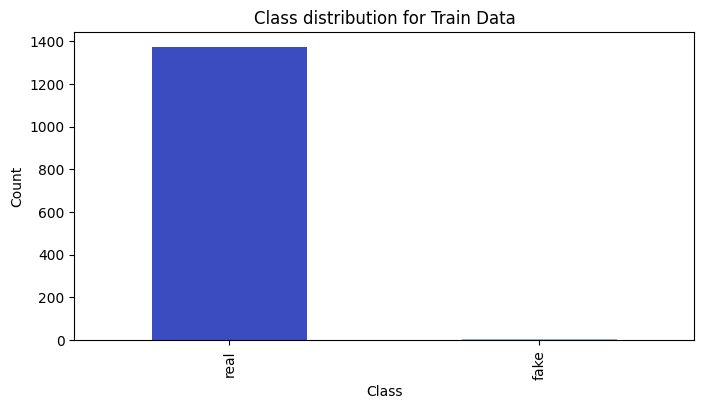

In [9]:
df = pd.read_csv(f'{BASE_PATH}/train_essays.csv')  # Read CSV file into a DataFrame
df['label'] = df.generated.copy()
df['name'] = df.generated.map(CFG.label2name)  # Map answer labels using name-to-label mapping

# Display information about the train data
print("# Train Data: {:,}".format(len(df)))
print("# Sample:")
display(df.head(2))

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for Train Data")
plt.show()


## External Datasets

We'll be utilizing the following external datasets:

* [Proper Train Dataset](https://www.kaggle.com/datasets/thedrcat/daigt-proper-train-dataset/) @thedrcat
* [ArguGPT](https://www.kaggle.com/datasets/alejopaullier/argugpt) @alejopaullier


# External Data: 27,827
# Sample:


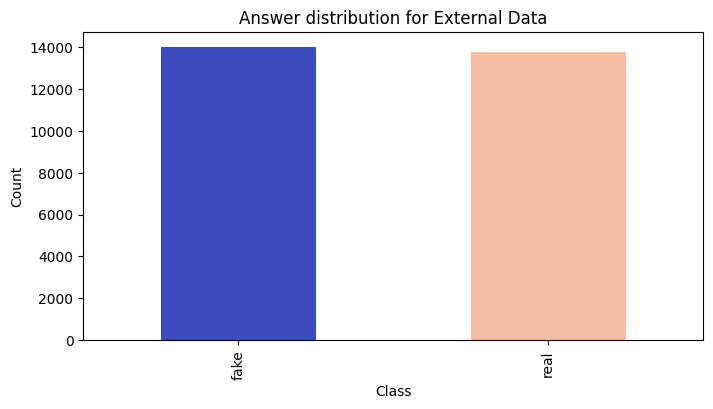

In [10]:
# Load external data
ext_df1 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv')
ext_df2 = pd.read_csv('/kaggle/input/argugpt/argugpt.csv')[['id','text','model']]

ext_df2.rename(columns={'model':'source'}, inplace=True)
ext_df2['label'] = 1

ext_df = pd.concat([
    ext_df1[ext_df1.source=='persuade_corpus'].sample(10000),
    ext_df1[ext_df1.source!='persuade_corpus'],
    ext_df2,
])

# ext_real_df = ext_df[['id', 'text']].copy()
# ext_real_df['label']  = 0

# ext_fake_df = ext_df[['id', 'source_text']].copy()
# ext_fake_df.rename(columns={"source_text":"text"}, inplace=True)
# ext_fake_df['label']  = 1

# ext_df = pd.concat([ext_real_df, ext_fake_df], axis=0)
ext_df['name'] = ext_df.label.map(CFG.label2name)

# Display information about the external data
print("# External Data: {:,}".format(len(ext_df)))
print("# Sample:")
ext_df.head(2)

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
ext_df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.65)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Answer distribution for External Data")
plt.show()

## Combine External and Train Data

In [11]:
df = ext_df.copy().reset_index(drop=True) # pd.concat([ext_df, df], axis=0)
df.head()

,essay_id,text,label,source,prompt,fold,id,name
0,960BA7EF10B0,Why You should Join the Seagoing Cowboys\n\nTh...,0,persuade_corpus,NaN,3.0,NaN,real
1,80D6E256AA49,Landform or alien? The face on Mars looks pret...,0,persuade_corpus,NaN,1.0,NaN,real
2,BE192DD5C8E2,Driveress cars have developed a lot in advanci...,0,persuade_corpus,NaN,3.0,NaN,real
3,D89BA0E02070,Limmiting car usage could be benificial to our...,0,persuade_corpus,NaN,8.0,NaN,real
4,7F23522935FD,Every student has different and unique interes...,0,persuade_corpus,NaN,9.0,NaN,real


# 🔪 | Data Split

In the code snippet provided below, we will divide the existing **train** data into folds using a stratification of `label` column.

In [12]:
from sklearn.model_selection import StratifiedKFold  # Import package

skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)  # Initialize K-Fold

df = df.reset_index(drop=True)  # Reset dataframe index

df['stratify'] = df.label.astype(str)+df.source.astype(str)

df["fold"] = -1  # New 'fold' column

# Assign folds using StratifiedKFold
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['stratify'])):
    df.loc[val_idx, 'fold'] = fold

# Display label distribution for each fold
df.groupby(["fold", "name", "source"]).size()

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


fold  name  source          
0     fake  chat_gpt_moth        484
            falcon_180b_v1       211
            gpt-3.5-turbo        163
            gpt2-xl               80
            llama2_chat          485
                                ... 
4     fake  text-davinci-002     102
            text-davinci-003     161
      real  original_moth        484
            persuade_corpus     2000
            train_essays         275
Length: 83, dtype: int64

# 🍽️ | Preprocessing

**What it does:** The preprocessor takes input strings and transforms them into a dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming `"The quick brown fox"` into `["the", "qu", "##ick", "br", "##own", "fox"]`, we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

Explore the following pages to access the available preprocessing and tokenizer layers in **KerasNLP**:
- [Preprocessing](https://keras.io/api/keras_nlp/preprocessing_layers/)
- [Tokenizers](https://keras.io/api/keras_nlp/tokenizers/)

In [13]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

2464616/2464616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step       


Now, let's examine what the output shape of the preprocessing layer looks like. The output shape of the layer can be represented as $(num\_choices, sequence\_length)$.

In [14]:
inp = preprocessor(df.text.iloc[0])  # Process text for the first row

# Display the shape of each processed output
for k, v in inp.items():
    print(k, ":", v.shape)

token_ids : torch.Size([200])
padding_mask : torch.Size([200])


We'll use the `preprocessing_fn` function to transform each text option using the `dataset.map(preprocessing_fn)` method.

In [15]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

# 🍚 | DataLoader

The code below sets up a robust data flow pipeline using `tf.data.Dataset` for data processing. Notable aspects of `tf.data` include its ability to simplify pipeline construction and represent components in sequences.

To learn more about `tf.data`, refer to this [documentation](https://www.tensorflow.org/guide/data).

In [16]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=False, drop_remainder=True,
                  repeat=False, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    ds = ds.repeat() if repeat else ds  # Repeat dataset if enabled
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

## Fetch Train/Valid Dataset

The function below generates the training and validation datasets for a given fold.

In [17]:
def get_datasets(fold):
    train_df = df[df.fold!=fold].sample(frac=1)  # Get training fold data
        
    train_texts = train_df.text.tolist()  # Extract training texts
    train_labels = train_df.label.tolist()  # Extract training labels
    
    # Build training dataset
    train_ds = build_dataset(train_texts, train_labels,
                             batch_size=CFG.batch_size*CFG.replicas, cache=CFG.cache,
                             shuffle=True, drop_remainder=True, repeat=True)

    valid_df = df[df.fold==fold].sample(frac=1)  # Get validation fold data
    valid_texts = valid_df.text.tolist()  # Extract validation texts
    valid_labels = valid_df.label.tolist()  # Extract validation labels
    
    # Build validation dataset
    valid_ds = build_dataset(valid_texts, valid_labels,
                             batch_size=min(CFG.batch_size*CFG.replicas, len(valid_df)), cache=CFG.cache,
                             shuffle=False, drop_remainder=True, repeat=False)
    
    return (train_ds, train_df), (valid_ds, valid_df)  # Return datasets and dataframes

# 🪄 | Wandb
<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

To monitor the training of my text-based model, I'll make use of **Weights & Biases**. Weights & Biases (W&B) is an MLOps platform that offers experiment tracking, dataset versioning, and model management functionalities, aiding in efficient model development. 

In [18]:
import wandb  # Import wandb library for experiment tracking
# import wandb_addons # Additional wandb utilities

try:
    from kaggle_secrets import UserSecretsClient  # Import UserSecretsClient
    user_secrets = UserSecretsClient()  # Create secrets client instance
    api_key = user_secrets.get_secret("WANDB")  # Get API key from Kaggle secrets
    wandb.login(key=api_key)  # Login to wandb with the API key
    anonymous = None  # Set anonymous mode to None
except:
    anonymous = 'must'  # Set anonymous mode to 'must'
    wandb.login(anonymous=anonymous, relogin=True)  # Login to wandb anonymously and relogin if needed

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Logger

The following code cell contains code to log data to WandB. It is noteworthy that the newly released callbacks offer more flexibility in terms of customization, and they are more compact compared to the classic `WandbCallback`, making it easier to use. Here's a brief introduction to them:

* **WandbModelCheckpoint**: This callback saves the model or weights using `tf.keras.callbacks.ModelCheckpoint`. Hence, we can harness the power of the official TensorFlow callback to log even `tf.keras.Model` subclass model in TPU.
* **WandbMetricsLogger**: This callback simply logs all the metrics and losses.
* **WandbEvalCallback**: This one is even more special. We can use it to log the model's prediction after a certain epoch/frequency. We can use it to save segmentation masks, bounding boxes, GradCAM within epochs to check intermediate results and so on.

For more details, please check the [official documentation](https://docs.wandb.ai/ref/python/integrations/keras).

In [19]:
from wandb.keras import WandbMetricsLogger
from wandb.keras import WandbModelCheckpoint


# Initializes the W&B run with a config file and W&B run settings.
def wandb_init(fold):
    config = {k: v for k, v in dict(vars(CFG)).items() if '__' not in k}  # Create config dictionary
    config.update({"fold": int(fold)})  # Add fold to config
    run = wandb.init(project="llm-fake-text",
                     name=f"fold-{fold}|max_seq-{CFG.sequence_length}|model-{CFG.preset}",
                     config=config,
                     group=CFG.comment,
                     save_code=True)
    return run

# Log best result for error analysis
def log_wandb():
    wandb.log({'best_auc': best_acc, 'best_loss': best_loss, 'best_epoch': best_epoch})

# Fetch W&B callbacks
def get_wb_callbacks(fold):
    wb_ckpt = WandbModelCheckpoint(f'fold{fold}.keras',
                                   monitor='val_auc',
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='max')
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_metr, wb_ckpt]  # Return WandB callbacks


# ⚓ | LR Schedule

Implementing a learning rate scheduler is crucial for transfer learning. The learning rate initiates at `lr_start` and gradually tapers down to `lr_min` using various techniques, including:
- `step`: Lowering the learning rate in step-wise manner resembling stairs.
- `cos`: Utilizing a cosine curve to gradually reduce the learning rate.
- `exp`: Exponentially decreasing the learning rate.

**Importance:** A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [20]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-6, 0.5e-6 * batch_size, 0.3e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 1, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

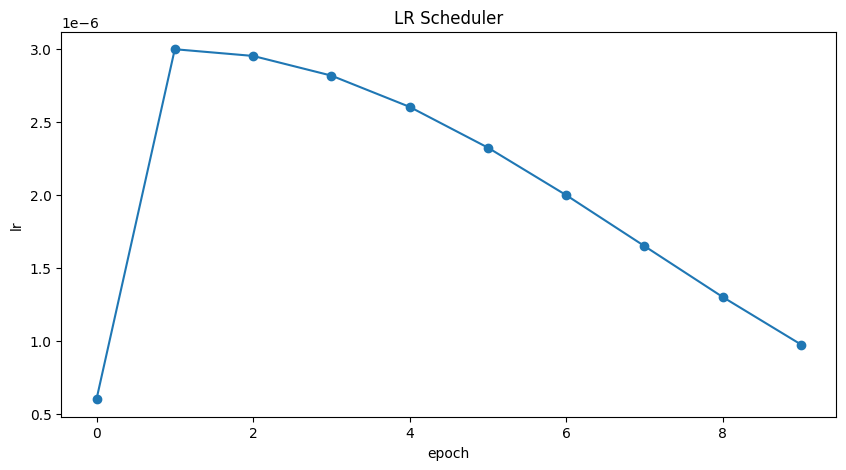

In [21]:
_=get_lr_callback(CFG.batch_size*CFG.replicas, plot=True)

# ☎️ | Callbacks

The function below will gather all the training callbacks, such as `lr_scheduler`, `model_checkpoint`, `wandb_logger`, and etc.

In [22]:
def get_callbacks(fold):
    callbacks = []
    lr_cb = get_lr_callback(CFG.batch_size*CFG.replicas)  # Get lr callback
    ckpt_cb = keras.callbacks.ModelCheckpoint(f'fold{fold}.keras',
                                              monitor='val_auc',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              mode='max')  # Get Model checkpoint callback
    callbacks.extend([lr_cb, ckpt_cb])  # Add lr and checkpoint callbacks

    if CFG.wandb:  # If WandB is enabled
        wb_cbs = get_wb_callbacks(fold)  # Get WandB callbacks
        callbacks.extend(wb_cbs) 
        
    return callbacks  # Return the list of callbacks

# 🤖 | Modeling



## KerasNLP Classifier

<img src="https://keras.io/img/logo.png" width="400">

The `KerasNLP` library provides comprehensive, ready-to-use implementations of popular NLP model architectures. It features a variety of pre-trained models including `Bert`, `Roberta`, `DebertaV3`, and more. In this notebook, we'll showcase the usage of `DebertaV3`. However, feel free to explore all available models in the [KerasNLP documentation](https://keras.io/api/keras_nlp/models/). Also for a deeper understanding of `KerasNLP`, refer to the informative [getting started guide](https://keras.io/guides/keras_nlp/getting_started/).

Our approach involves using `keras_nlp.models.XXClassifier` to process each text and generatie logits. These logits are passed through a `softmax` function to produce the final output.

In [23]:
def build_model():
    # Create a DebertaV3Classifier model
    classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
        CFG.preset,
        preprocessor=None,
        num_classes=1 # one output per one option, for five options total 5 outputs
    )
    inputs = classifier.input
    logits = classifier(inputs)
        
    # Compute final output
    outputs = keras.layers.Activation("sigmoid")(logits)
    model = keras.Model(inputs, outputs)
    
    # Compile the model with optimizer, loss, and metrics
    model.compile(
        optimizer=keras.optimizers.AdamW(5e-6),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.02),
        metrics=[
            keras.metrics.AUC(name="auc"),
        ],
        jit_compile=True
    )
    return model

In [24]:
# with strategy.scope
model = build_model()

735557816/735557816 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/opt/conda/lib/python3.10/site-packages/keras_core/src/trainers/trainer.py:166: UserWarning: `jit_compile` is not yet enabled for the PyTorch backend. Proceeding with `jit_compile=False`.
  warnings.warn(


### Model Summary

In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ token_ids           │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ deberta_v3_classif… │ (None, 1)         │ 184,42… │ padding_mask[0][0],  │
│ (DebertaV3Classifi… │                   │         │ token_ids[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation          │ (None, 1)         │       0 │ deberta_v3_classifi… │
│ (Activation)        │                   │         │                      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 184,422,913 (703.52 MB)

 Trainable params: 184,422,913 (703.52 MB)

 Non-trainable params: 0 (0.00 B)

### Model Plot

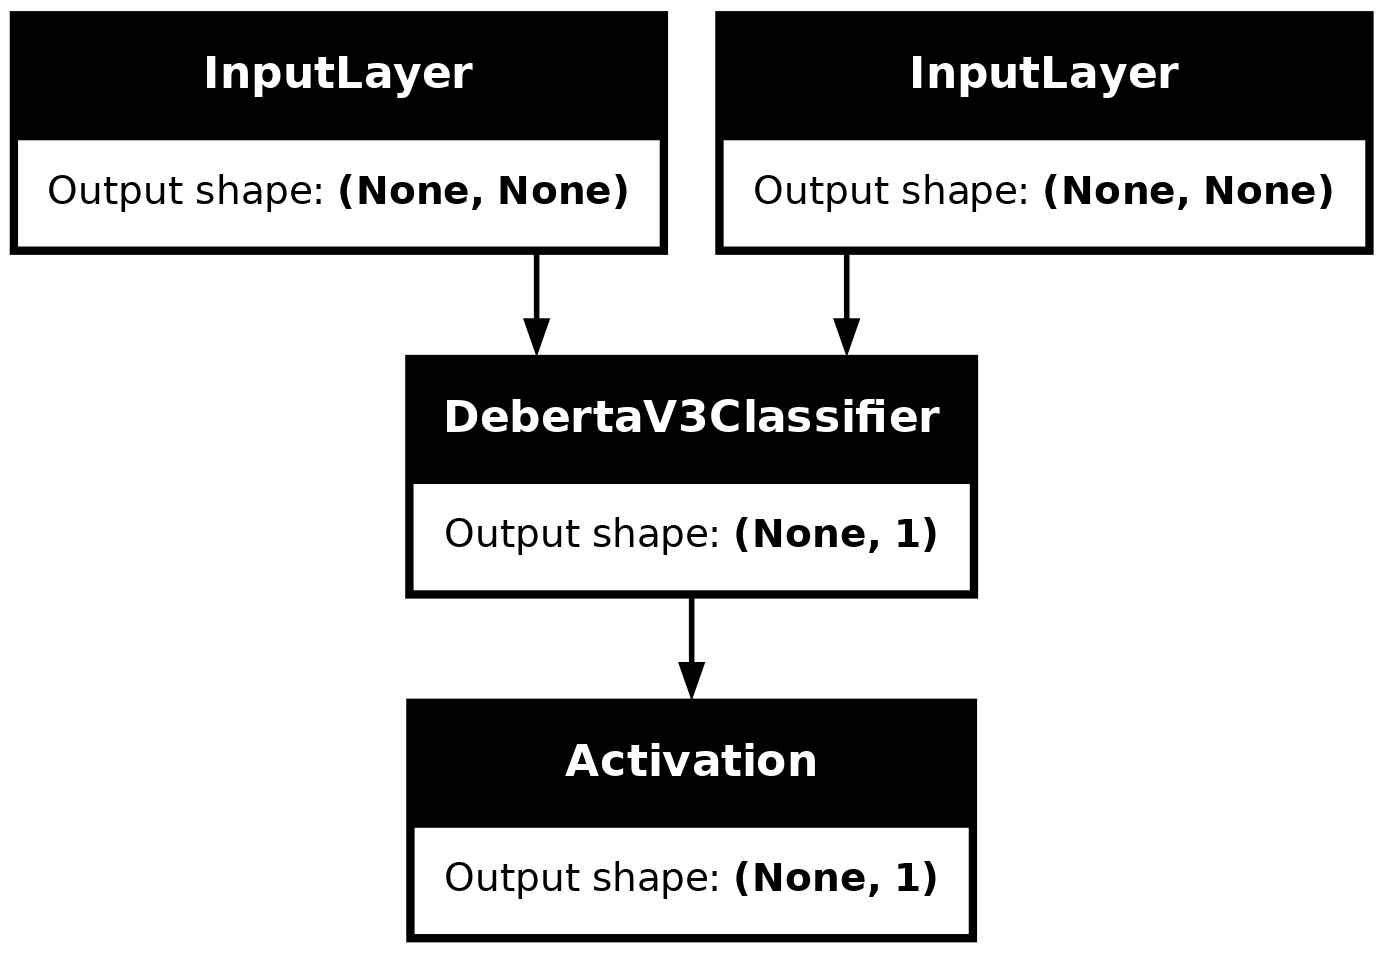

In [26]:
keras.utils.plot_model(model, show_shapes=True)

# 🚂 | Training

In [27]:
for fold in CFG.selected_folds:
    # Initialize Weights and Biases if enabled
    if CFG.wandb:
        run = wandb_init(fold)

    # Get train and validation datasets
    (train_ds, train_df), (valid_ds, valid_df) = get_datasets(fold)
    
    # Get callback functions for training
    callbacks = get_callbacks(fold)

    # Print training information
    print('#' * 50)
    print(f'\tFold: {fold + 1} | Model: {CFG.preset}\n\tBatch Size: {CFG.batch_size * CFG.replicas} | Scheduler: {CFG.scheduler}')
    print(f'\tNum Train: {len(train_df)} | Num Valid: {len(valid_df)}')
    print('#' * 50)
    
    # Clear TensorFlow session and build the model within the strategy scope
    K.clear_session()
    with strategy.scope():
        model = build_model()

    # Start training the model
    history = model.fit(
        train_ds,
        epochs=CFG.epochs,
        validation_data=valid_ds,
        callbacks=callbacks,
        steps_per_epoch=int(len(train_df) / CFG.batch_size / CFG.replicas),
    )
    
    # Find the epoch with the best validation accuracy
    best_epoch = np.argmax(model.history.history['val_auc'])
    best_auc = model.history.history['val_auc'][best_epoch]
    best_loss = model.history.history['val_loss'][best_epoch]

    # Print and display best results
    print(f'\n{"=" * 17} FOLD {fold} RESULTS {"=" * 17}')
    print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST AUC   : {best_auc:.3f}\n>>>> BEST Epoch : {best_epoch}')
    print('=' * 50)
    
    # Log best result on Weights and Biases (wandb) if enabled
    if CFG.wandb:
        log_wandb()  # Log results
        wandb.run.finish()  # Finish the run
#         display(ipd.IFrame(run.url, width=1080, height=720)) # show wandb dashboard
    print("\n\n")

##################################################
	Fold: 1 | Model: deberta_v3_base_en
	Batch Size: 6 | Scheduler: cosine
	Num Train: 22261 | Num Valid: 5566
##################################################


/opt/conda/lib/python3.10/site-packages/keras_core/src/trainers/trainer.py:166: UserWarning: `jit_compile` is not yet enabled for the PyTorch backend. Proceeding with `jit_compile=False`.
  warnings.warn(


Epoch 1/3
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 1858s 500ms/step - auc: 0.9291 - loss: 0.3051 - val_auc: 0.9978 - val_loss: 0.1339 - learning_rate: 6.0000e-07
Epoch 2/3
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 1859s 501ms/step - auc: 0.9995 - loss: 0.0722 - val_auc: 0.9986 - val_loss: 0.1299 - learning_rate: 3.0000e-06
Epoch 3/3
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 1858s 501ms/step - auc: 0.9999 - loss: 0.0607 - val_auc: 0.9996 - val_loss: 0.0752 - learning_rate: 2.9540e-06

================= FOLD 0 RESULTS =================
>>>> BEST Loss  : 0.075
>>>> BEST AUC   : 1.000
>>>> BEST Epoch : 2



##################################################
	Fold: 2 | Model: deberta_v3_base_en
	Batch Size: 6 | Scheduler: cosine
	Num Train: 22261 | Num Valid: 5566
##################################################
Epoch 1/3
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 1862s 502ms/step - auc: 0.9087 - loss: 0.3327 - val_auc: 0.9988 - val_loss: 0.1171 - learning_rate: 6.0000e-07
Epoch 2/3
3710/3710 ━━━━━━━━━━━━━━━━━━━━ 1853s 499ms/step -

## Training Log
### [Click Here ➡️](https://wandb.ai/awsaf49/llm-science-exam-public) to check all the training logs in **WandB** dashboard.

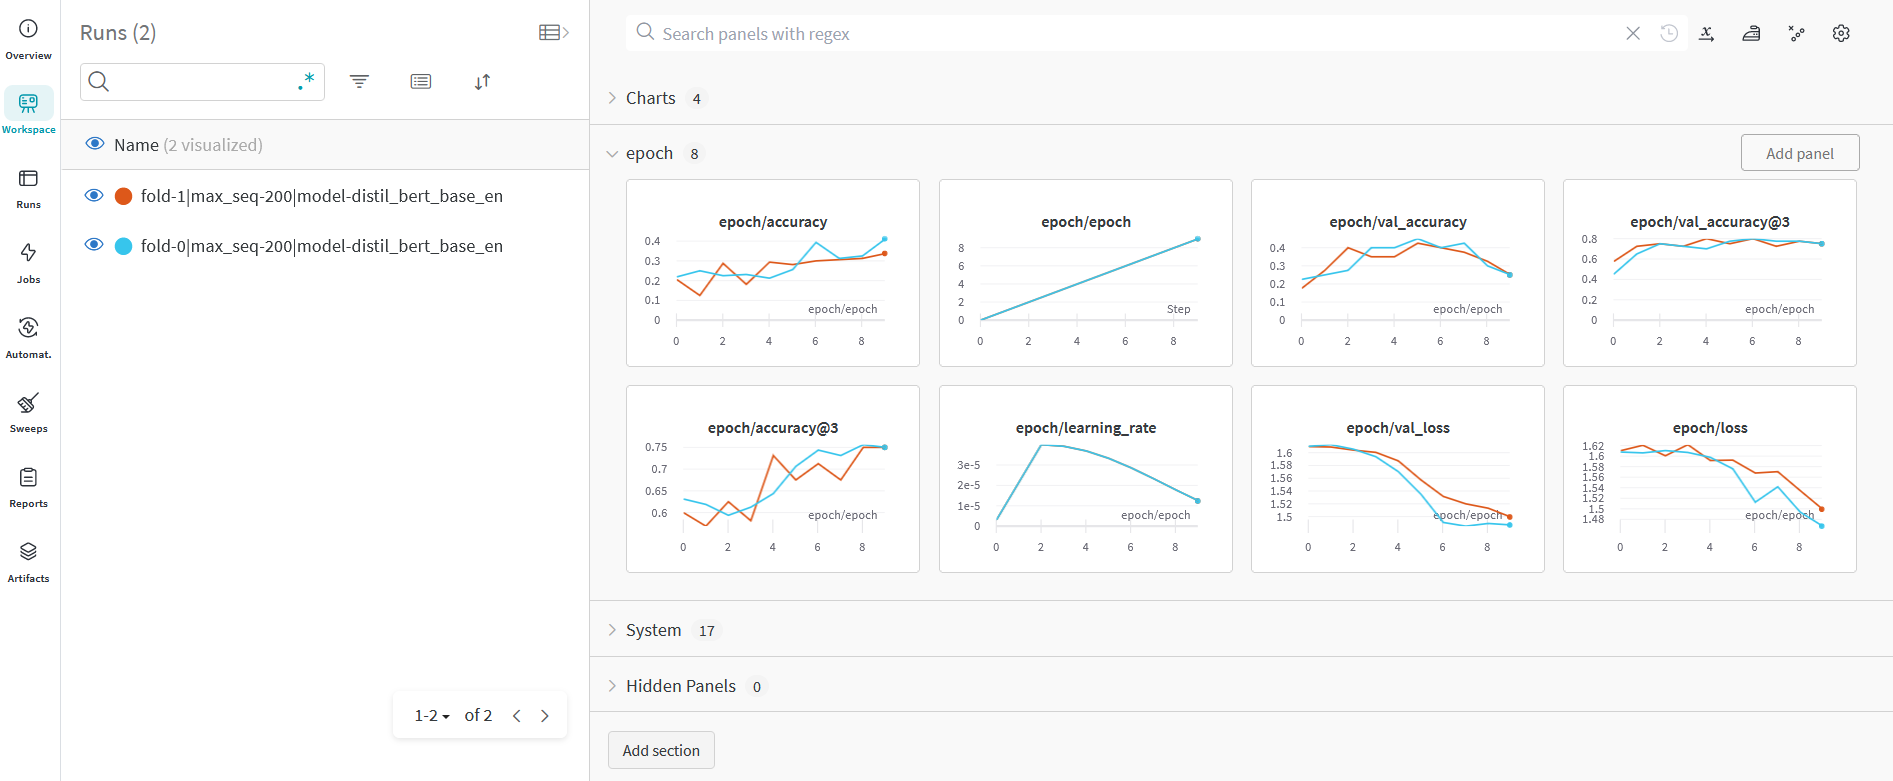

# 🧪 | Prediction

In [28]:
# Make predictions using the trained model on last validation data
predictions = model.predict(
    valid_ds,
    batch_size=min(CFG.batch_size * CFG.replicas * 2, len(valid_df)), # max batch size = valid size
    verbose=1
)

927/927 ━━━━━━━━━━━━━━━━━━━━ 131s 141ms/step


In [29]:
# Format predictions and true answers
pred_answers = (predictions > 0.5).astype(int).squeeze()
true_answers = valid_df.label.values

# Check 5 Predictions
print("# Predictions\n")
for i in range(5):
    row = valid_df.iloc[i]
    text  = row.text
    pred_answer = CFG.label2name[pred_answers[i]]
    true_answer = CFG.label2name[true_answers[i]]
    print(f"❓ Text {i+1}:\n{text[:100]} .... {text[-100:]}\n")
    print(f"✅ True: {true_answer}\n")
    print(f"🤖 Predicted: {pred_answer}\n")
    print("-"*90, "\n")

# Predictions

❓ Text 1:
Hey there!  So, you wanna know about the power of having a good attitude?  Well, let me tell ya, it' ....  mindset, and that can lead to better outcomes. And who doesn't want that? 

In conclusion, having a

✅ True: fake

🤖 Predicted: fake

------------------------------------------------------------------------------------------ 

❓ Text 2:
"Seeking multiple opinions can help someone make a better choice because it gives them different per .... tiple people for advice can help you make a better choice and feel more confident in your decision."

✅ True: fake

🤖 Predicted: fake

------------------------------------------------------------------------------------------ 

❓ Text 3:
Dear Mrs. Smith,

I am wryting to you today to gve my oppinion on the new policy that you are thinki .... not implement this policy and instead find other ways to motivate students.

Sincerely,

[Your Name]

✅ True: fake

🤖 Predicted: fake

----------------------------------------------

# ✍️ | Reference
* [LLM Science Exam: KerasCore + KerasNLP [TPU]](https://www.kaggle.com/code/awsaf49/llm-science-exam-kerascore-kerasnlp-tpu)
* [Keras NLP](https://keras.io/api/keras_nlp/)
* [Triple Stratified KFold with TFRecords](https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords) by @cdeotte

In [30]:
!rm -r /kaggle/working/wandb  

rm: cannot remove '/kaggle/working/wandb': No such file or directory
